In [1]:
%pwd
from theano.sandbox import cuda
cuda.use('gpu0')
%matplotlib inline

ERROR (theano.sandbox.cuda): Failed to compile cuda_ndarray.cu: libcublas.so.8.0: cannot open shared object file: No such file or directory
WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu0 is not available  (error: cuda unavailable)


In [2]:
import os
base= os.getcwd() + "/data/redux"
base= os.getcwd() + "/data/redux/sample"
train= base+"/train"
test= base+"/test"
valid= base+"/valid"
results_path = base+"/results"


In [3]:
from matplotlib import pyplot as plt
import bcolz
def plot(img):
    plt.imshow(img)
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

In [5]:

    
import json   
import keras.preprocessing.image as preprocess
from keras.models import Sequential
import numpy as np
from keras.layers.core import Lambda, Flatten, Dropout, Dense
from keras.layers.convolutional import ZeroPadding2D, Convolution2D, MaxPooling2D
from keras.utils.data_utils import get_file
from keras.optimizers import Adam


vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))
def vgg_preprocess(x):
    """
        Subtracts the mean RGB value, and transposes RGB to BGR.
        The mean RGB was computed on the image set used to train the VGG model.

        Args: 
            x: Image array (height x width x channels)
        Returns:
            Image array (height x width x transposed_channels)
    """
    x = x - vgg_mean
#     print x
#     import pdb;pdb.set_trace()
    return x[:, ::-1] # reverse axis rgb->bgr

class hgg:
    def get_classes(self):
        fname = 'imagenet_class_index.json'
        fpath = get_file(fname, self.FILE_PATH+fname, cache_subdir='models')
        with open(fpath) as f:
            class_dict = json.load(f)
        self.classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

    def get_batches(self,path, shuffle=True, batch_size=8, rotation_range=10 ,width_shift_range=10, height_shift_range=10, shear_range=0.3 ):
#         imageGenerator doc at https://keras.io/preprocessing/image/
        imageGenerator = preprocess.ImageDataGenerator(
#             rotation_range=rotation_range,
#             width_shift_range=width_shift_range,
#             height_shift_range=height_shift_range,
#             shear_range=shear_range,
#             zoom_range=0
        )
        return imageGenerator.flow_from_directory(
            shuffle=shuffle,
            directory=path, 
            target_size=(224,224),
            batch_size=batch_size,
            class_mode='categorical'
        )
    def __init__(self):
        self.FILE_PATH = 'http://files.fast.ai/models/'

        self.createModel()
        self.get_classes()
        pass
    def createModel(self,):
        # Sequential doc at https://keras.io/getting-started/sequential-model-guide/
        self.model=Sequential()
        self.model.add(Lambda(vgg_preprocess, input_shape=(3,224,224), output_shape=(3,224,224)))
        self.addConvLayer(2,64)
        self.addConvLayer(2,128)
        self.addConvLayer(3,256)
        self.addConvLayer(3,512)
        self.addConvLayer(3,512)
        
        self.model.add(Flatten())
        
        self.model.add(Dense(4096,activation='relu'))
        self.model.add(Dropout(0.5))
        
        self.model.add(Dense(4096,activation='relu'))
        self.model.add(Dropout(0.5))
        
        
        self.model.add(Dense(1000,activation='softmax'))
        
        
        fname="vgg16.h5"
        self.model.load_weights(get_file(fname, self.FILE_PATH+fname, cache_subdir='models'))
        
    def addConvLayer(self,layers,filters):
        # Convolution2D https://keras.io/layers/convolutional/
        for i in range(layers):
            self.model.add(ZeroPadding2D((1,1)))
            self.model.add(Convolution2D(filters,3,3,activation='relu'))
        self.model.add(MaxPooling2D((2,2),strides=(2,2)))
        
    def ModifyLastLayerToNewOutput(self, no_of_outputs):
        self.model.pop()
        for layer in self.model.layers: layer.trainable=False
        self.model.add(Dense(no_of_outputs,activation='softmax'))
        print no_of_outputs
        self.compile()
    def finetune(self,batches):
        self.ModifyLastLayerToNewOutput(batches.nb_class)
        classes = list(iter(batches.class_indices)) # get a list of all the class labels
        
        # batches.class_indices is a dict with the class name as key and an index as value
        # eg. {'cats': 0, 'dogs': 1}

        # sort the class labels by index according to batches.class_indices and update model.classes
        for c in batches.class_indices:
            classes[batches.class_indices[c]] = c
        self.classes = classes
        
        
    def compile(self, lr=0.001):
        self.model.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy',metrics=['accuracy'])
    def fit(self,train_batches, validation_batches):
        self.model.fit_generator(train_batches, 
                        samples_per_epoch = train_batches.nb_sample,
                        nb_epoch=1, 
                        validation_data = validation_batches,
                        nb_val_samples = validation_batches.nb_sample,
                       )
   
h = hgg()
# from vgg16 import Vgg16

# h=Vgg16()

In [6]:
batch_size=8
train_batches = h.get_batches(train, batch_size=batch_size)
validation_batches = h.get_batches(valid, batch_size=batch_size)
test_batches = h.get_batches(test, batch_size=batch_size)
# validation_batches
# plot(validation_batches)


Found 200 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 1223 images belonging to 1 classes.


In [7]:
h.finetune(train_batches)

2


In [8]:
train_now=False

no_of_epochs=3
if train_now==True:
    latest_weights_filename = None
    for epoch in range(no_of_epochs):
        print "Running epoch: %d" % epoch
        if(epoch>=2):
            h.model.optimizer.lr = 0.001
        h.fit(train_batches, validation_batches)
        latest_weights_filename = '/ft%d.h5' % epoch
        h.model.save_weights(results_path+latest_weights_filename)
    print "Completed %s fit operations" % no_of_epochs
else:
    print "loading from saved_model"
    h.model.load_weights(results_path+"/ft2.h5")
    


loading from saved_model


In [9]:
preds=h.model.predict_generator(validation_batches, validation_batches.nb_sample)

In [10]:
is_dog = np.round(1- preds)
print is_dog[:5]
filenames = validation_batches.filenames
print filenames[:5]
print len(preds)

[[ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]]
['cats/cat.375.jpg', 'cats/cat.6339.jpg', 'cats/cat.6905.jpg', 'cats/cat.2513.jpg', 'cats/cat.4418.jpg']
50


In [11]:
with open("submit.txt","a") as f:
    f.write("id,label\n")
    for i in range(len(preds)):
        if(is_dog[i][0]==1):
            is_dog[i][0]=0.05
        else:
            is_dog[i][0]=0.95
        print filenames[i][8:-4],",",is_dog[i][0]
        f.write("%s,%s\n"%(str(filenames[i][8:-4]),str(is_dog[i][0])) )

.375 , 0.95
.6339 , 0.95
.6905 , 0.95
.2513 , 0.05
.4418 , 0.05
.1367 , 0.05
.7126 , 0.95
.5802 , 0.05
.10 , 0.95
.444 , 0.95
.6389 , 0.05
.4538 , 0.05
.4139 , 0.05
.11366 , 0.95
.10008 , 0.05
.3892 , 0.95
.1358 , 0.05
.281 , 0.05
.2489 , 0.95
.3981 , 0.05
.12461 , 0.95
.3458 , 0.95
.7277 , 0.05
.96 , 0.05
.9519 , 0.05
.6839 , 0.05
.7195 , 0.05
.10084 , 0.05
.822 , 0.05
.2906 , 0.05
.9731 , 0.95
.5013 , 0.05
.12369 , 0.05
.9832 , 0.05
.5891 , 0.95
.9541 , 0.95
.10554 , 0.05
.5236 , 0.05
.2344 , 0.05
.1730 , 0.95
.8231 , 0.95
.7547 , 0.05
.1410 , 0.05
.6330 , 0.05
.4541 , 0.05
.330 , 0.95
.5785 , 0.95
.6141 , 0.95
.10781 , 0.05
.3208 , 0.95


In [12]:
from PIL import Image
import random
isdog = preds[:,1]
isdog = isdog.clip(min=0.05, max=0.95)



46
[  9.99958932e-01   4.10473476e-05]
0.05
dogs/dog.5785.jpg
50


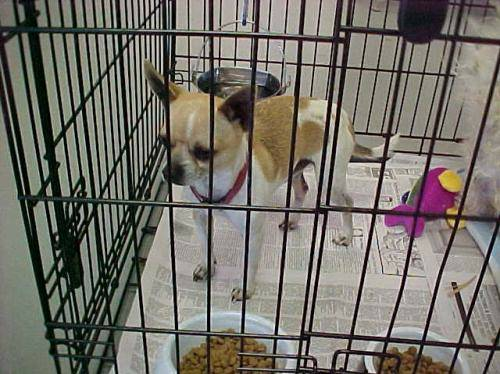

In [15]:
idx=int(random.random()*len(preds))
print idx
print preds[idx]
print isdog[idx]
print filenames[idx]
print len(preds)

Image.open(valid+"/" + filenames[idx])

[[11 11]
 [ 9 19]]


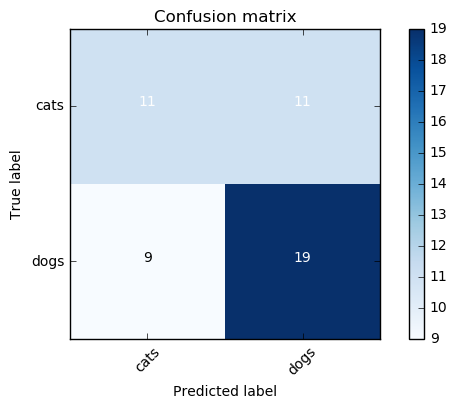

In [16]:
import itertools
from numpy.random import random, permutation
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(valid + "/" +filenames[i]) for i in idx], titles=titles)
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')


#Number of images to view for each visualization task
n_view = 4
from sklearn.metrics import confusion_matrix
expected_labels = validation_batches.classes #0 or 1

#Round our predictions to 0/1 to generate labels
our_predictions = preds[:,0]
our_labels = np.round(1-our_predictions)

cm = confusion_matrix(expected_labels, our_labels)
plot_confusion_matrix(cm, validation_batches.class_indices)

In [ ]:
save_array(results_path + '/test_preds.dat', preds)
save_array(results_path + '/filenames.dat', filenames)

In [ ]:
#1. A few correct labels at random
correct = np.where(our_labels==expected_labels)[0]
print "Found %d correct labels" % len(correct)
idx = permutation(correct)[:n_view]
print idx
plots_idx(idx, our_predictions[idx])